In [31]:
!nvidia-smi

Thu Feb 25 02:41:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    31W /  70W |    984MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [32]:
!unzip --q /content/drive/MyDrive/ColabNotebooks/AnomalyDetection/ECG5000.zip

Archive:  /content/drive/MyDrive/ColabNotebooks/AnomalyDetection/ECG5000.zip
replace ECG5000.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ECG5000.txt             
  inflating: ECG5000_TEST.arff       
  inflating: ECG5000_TEST.txt        
  inflating: ECG5000_TRAIN.arff      
  inflating: ECG5000_TRAIN.txt       
  inflating: ECG5000_TEST.ts         
  inflating: ECG5000_TRAIN.ts        


In [33]:
# package to convert arff to pandas <https://github.com/garicchi/arff2pandas>
!pip install -qq arff2pandas

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
import copy

from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
import torch.nn.functional as F

from arff2pandas import a2p

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid')
plt.style.use('ggplot')
rcParams['figure.figsize'] = 12,8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
with open('ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)

train.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.40638

In [37]:
with open('ECG5000_TEST.arff') as f:
  test = a2p.load(f)

test.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
0,3.690844,0.711414,-2.114091,-4.141007,-4.574472,-3.431909,-1.950791,-1.107067,-0.632322,0.334577,0.878836,0.831067,0.832466,0.790993,0.733184,0.675314,0.760751,0.645451,0.644724,0.593140,0.600701,0.496795,0.409546,0.330819,0.159581,0.200914,0.107753,-0.039165,-0.096833,-0.170630,-0.296952,-0.381269,-0.363097,-0.501362,-0.673076,-0.551881,-0.650941,-0.542608,-0.661102,-0.581184,...,0.912150,1.197038,1.525856,1.677409,1.493802,1.332885,1.033417,0.709380,0.504176,0.121977,-0.144692,-0.706222,-0.971959,-1.092812,-1.204838,-1.114166,-1.087325,-1.285353,-1.248159,-1.210142,-1.278470,-1.278924,-1.376985,-1.232817,-1.189943,-1.344416,-1.239010,-1.174265,-0.699666,-0.032477,0.022847,0.188937,0.480932,0.629250,0.577291,0.665527,1.035997,1.492287,-1.905073,1
1,-1.348132,-3.996038,-4.226750,-4.251187,-3.477953,-2.228422,-1.808488,-1.534242,-0.779861,-0.397999,-0.493585,-0.424566,-0.443613,-0.347533,-0.429206,-0.419432,-0.420668,-0.498734,-0.410890,-0.443809,-0.463833,-0.499894,-0.524206,-0.616694,-0.606410,-0.565365,-0.661417,-0.603203,-0.695499,-0.717034,-0.696853,-0.734096,-0.792403,-0.820478,-0.727217,-0.828315,-0.708753,-0.696388,-0.662056,-0.631873,...,1.167701,1.305410,1.500784,1.739557,1.977449,1.916066,1.899681,1.702459,1.579359,1.268397,1.021553,0.568299,0.150091,-0.044534,-0.090432,-0.144367,-0.131316,-0.110823,-0.088810,-0.095817,-0.082048,-0.053043,-0.189978,-0.111385,-0.128527,-0.047618,-0.016406,0.108356,0.293390,0.937984,1.570938,1.591394,1.549193,1.193077,0.515134,0.126274,0.267532,1.071148,-1.164009,1
2,1.024295,-0.590314,-1.916949,-2.806989,-3.527905,-3.638675,-2.779767,-2.019031,-1.980754,-1.440680,-0.842542,-0.829726,-0.790482,-0.785441,-0.835461,-0.796361,-0.771146,-0.815385,-0.735402,-0.798965,-0.679510,-0.683254,-0.739599,-0.815913,-0.902384,-0.813008,-0.855560,-0.793842,-0.853332,-0.843024,-0.844967,-0.917276,-0.979700,-1.031643,-0.958200,-1.008464,-1.043407,-1.009559,-1.001219,-0.953293,...,0.663832,0.939063,1.196396,1.238014,1.310015,1.594162,1.836205,1.873225,1.960083,1.803756,1.718425,1.592971,1.344949,1.166471,0.695750,0.279590,0.180811,0.201507,0.191033,0.153371,0.178460,0.263660,0.271427,0.271596,0.356748,0.257862,0.277773,0.331739,0.384731,0.368820,0.443502,0.827582,1.237007,1.235121,1.738103,1.800767,1.816301,1.473963,1.389767,1
3,0.545657,-1.014383,-2.316698,-3.634040,-4.196857,-3.758093,-3.194444,-2.221764,-1.588554,-1.202146,-0.589493,-0.455109,-0.201613,0.055583,-0.095133,0.023464,-0.291556,-0.405063,-0.269354,-0.197477,-0.032429,-0.501257,-0.399656,-0.283003,-0.202945,-0.570158,-0.777244,-0.419418,-0.375513,-0.638091,-0.969082,-0.780202,-0.617075,-0.898172,-0.970493,-0.774366,-0.650623,-0.680303,-1.015144,-0.970932,...,1.800425,2.146134,1.995252,1.892413,2.119649,1.480067,1.071041,1.186209,0.863298,0.301564,-0.126937,-0.301484,-0.436105,-0.284822,-0.224644,-0.

In [38]:
# concating train and test into a single dataset
df = train.append(test)
df.shape

(5000, 141)

In [39]:
# shuffle the dataset
df = df.sample(frac=1.0)

The dataset contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

5 types of heartbeats
- Normal (N)
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB)
- Unclassified Beat (UB).

**Note:** Consider everything other than Normal(N) as an anomaly

In [40]:
CLASS_NORMAL = 1

class_names = ['Normal', 'R on T', 'PVC', 'SP', 'UB']

In [41]:
# renaming target column name
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

## Data Exploration

In [42]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


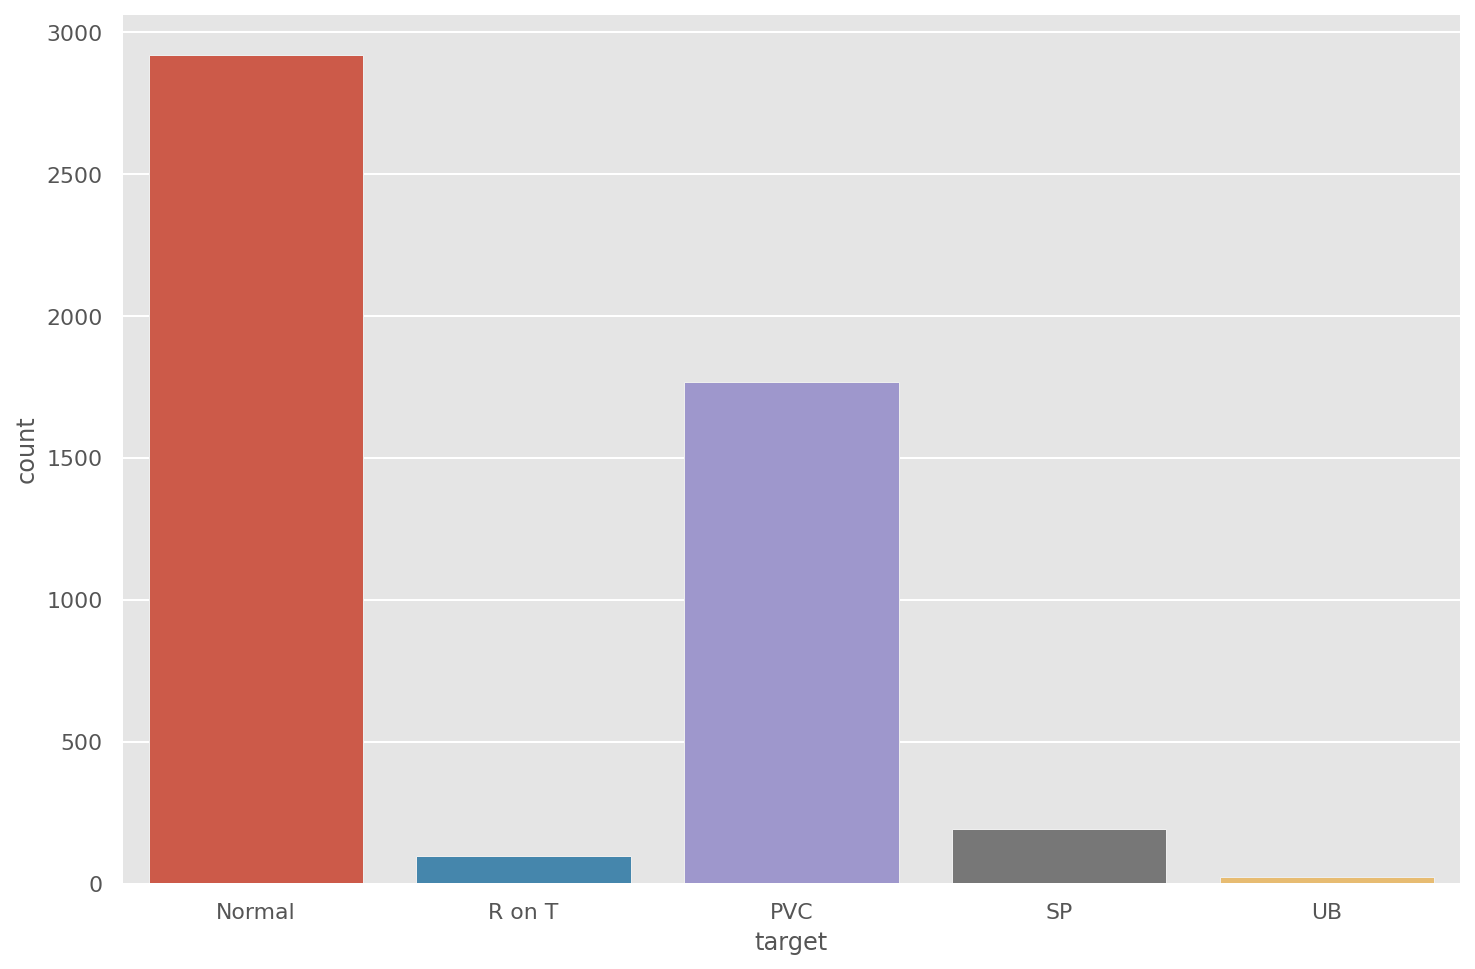

In [43]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names)
plt.show()

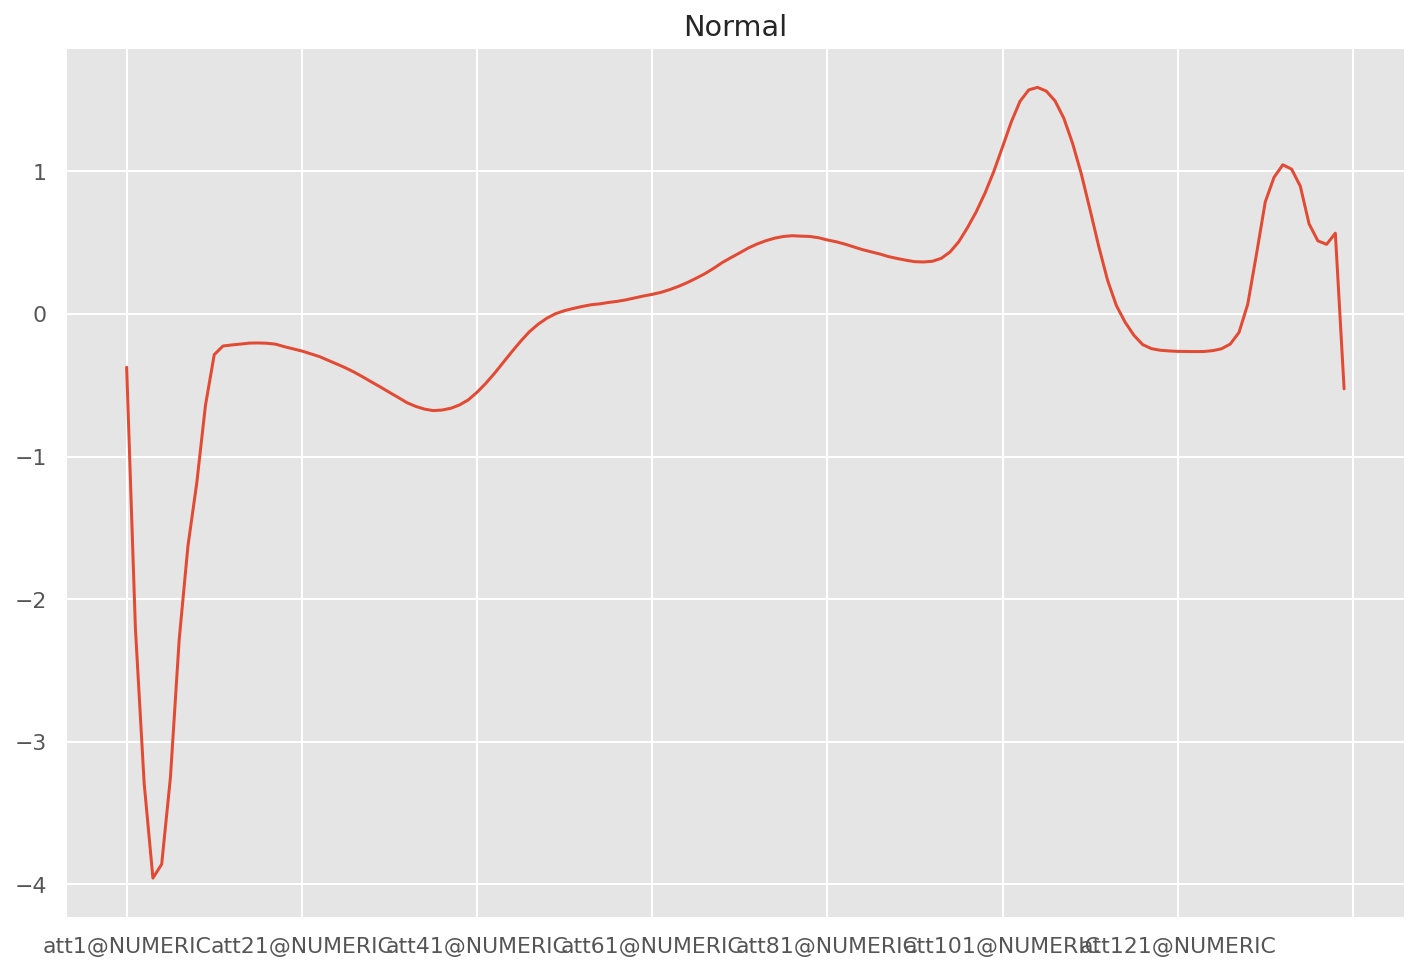

In [44]:
df[df.target==str(1)].drop(labels='target', axis=1).mean(axis=0).plot()
plt.title('Normal')
plt.show()

In [45]:
def plot_time_series_Class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)
  
  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2*time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
      path_deviation.index,
      under_line,
      over_line,
      alpha=0.125
  )
  ax.set_title(class_name)

<bound method Figure.tight_layout of <Figure size 1008x504 with 5 Axes>>

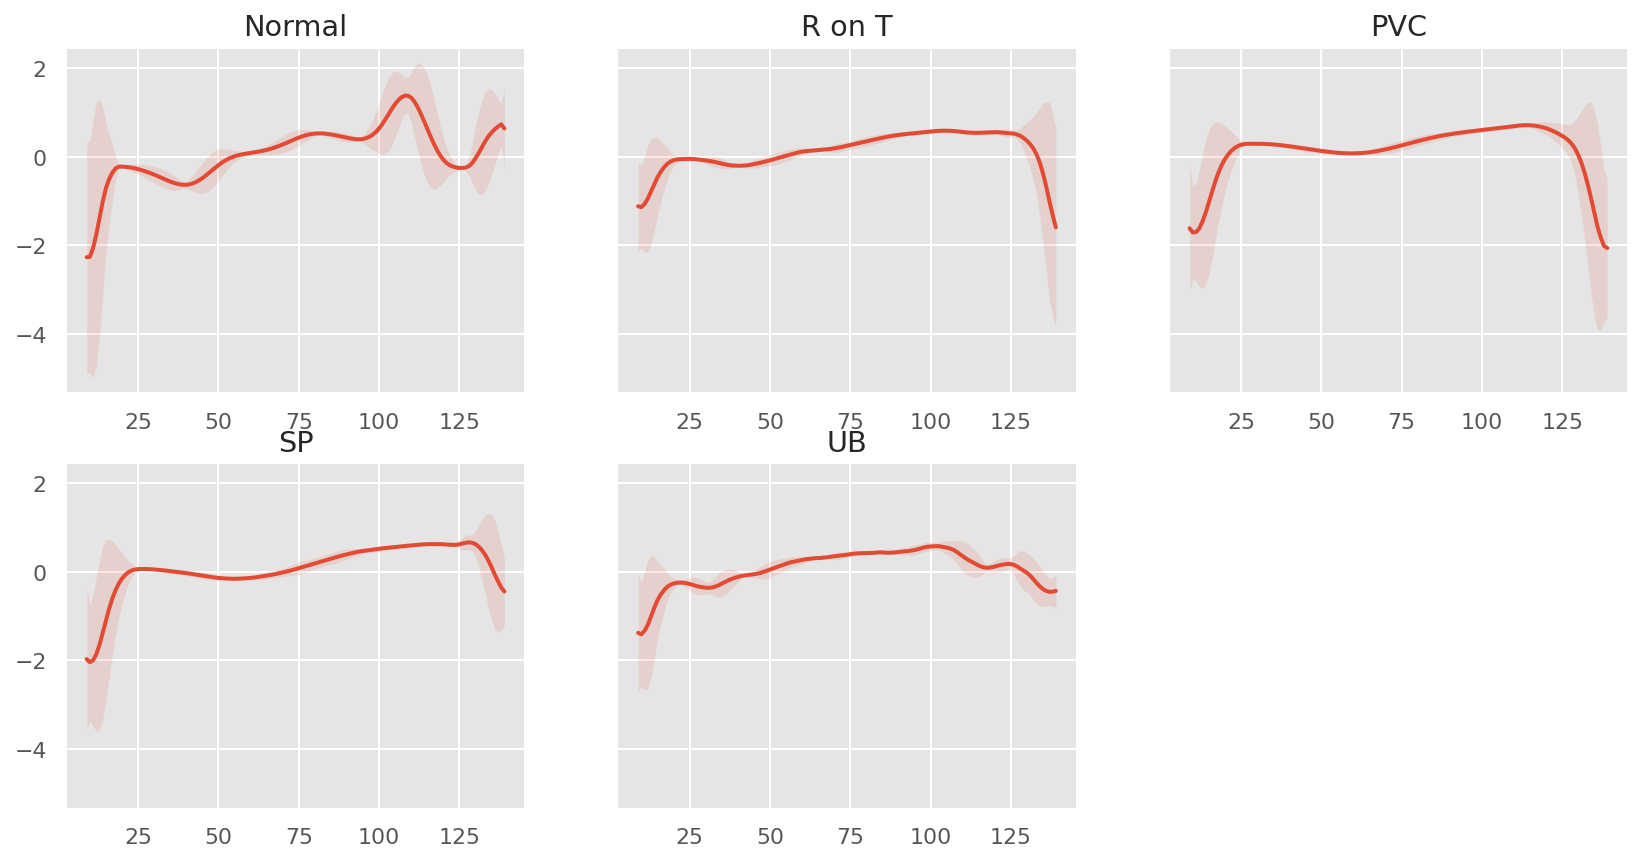

In [46]:
classes = df.target.unique()

fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14,7)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target==cls].drop(labels='target', axis=1).mean(axis=0).to_numpy()
  plot_time_series_Class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout

## Data Preprocessing

In [47]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [48]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [49]:
# splitting the 'normal_df' into train, validation and test sets
train_df, val_df = train_test_split(normal_df, test_size=0.17, random_state=RANDOM_SEED)

val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=RANDOM_SEED)

In [50]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(2422, 140)
(248, 140)
(249, 140)


In [51]:
# making list of arrays
train_series = train_df.astype(np.float32).to_numpy().tolist()
val_series = val_df.astype(np.float32).to_numpy().tolist()
test_series = test_df.astype(np.float32).to_numpy().tolist()
anomaly_series = anomaly_df.astype(np.float32).to_numpy().tolist()

In [52]:
# creating the dataset
def create_dataset(series):
  dataset = [torch.tensor(s).unsqueeze(1) for s in series]

  n_series, series_len, n_features = torch.stack(dataset).shape

  return dataset, series_len, n_features

In [53]:
train_dataset, series_len, n_features = create_dataset(train_series)
val_dataset, _, _ = create_dataset(val_series)
test_normal_dataset, _, _ = create_dataset(test_series)
test_anomaly_dataset, _, _ = create_dataset(anomaly_series)

## LSTM Autoencoder

In [54]:
  # Code taken from 'sequitur' library by "@Shobrook" with little modifications
  # link ->  `https://github.com/shobrook/sequitur`

In [55]:
 # Encoder class
class Encoder(nn.Module):

  def __init__(self, series_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()
    self.series_len, self.n_features = series_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, embedding_dim*2
    # rnn1
    self.rnn1 = nn.LSTM(
        input_size=n_features,
        hidden_size=self.hidden_dim,
        num_layers=1,
        batch_first=True
    )
    # rnn2
    self.rnn2 = nn.LSTM(
        input_size=self.hidden_dim,
        hidden_size=self.embedding_dim,
        num_layers=1,
        batch_first = True
    )

  def forward(self, x):
    x = x.reshape((1, series_len, self.n_features))
    x,(_,_) = self.rnn1(x)
    x,(hidden_n,_) = self.rnn2(x)
    return hidden_n.reshape((self.n_features, self.embedding_dim))

# Decoder class
class Decoder(nn.Module):

  def __init__(self, series_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()
    self.series_len, self.n_features = series_len, n_features
    self.input_dim, self.hidden_dim = input_dim, input_dim*2
    # rnn1
    self.rnn1 = nn.LSTM(
        input_size=input_dim,
        hidden_size=input_dim,
        num_layers=1,
        batch_first=True
    )
    # rnn2
    self.rnn2 = nn.LSTM(
        input_size = input_dim,
        hidden_size=self.hidden_dim,
        num_layers=1,
        batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.series_len, self.n_features)
    x = x.reshape((self.n_features, self.series_len, self.input_dim))
    x,(hidden_n, cell_n) = self.rnn1(x)
    x,(hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.series_len, self.hidden_dim))
    return self.output_layer(x)

class LSTMAutoencoder(nn.Module):

  def __init__(self, series_len, n_features, embedding_dim):
    super(LSTMAutoencoder, self).__init__()
    self.encoder = Encoder(series_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(series_len, embedding_dim, n_features).to(device)
  
  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [56]:
model = LSTMAutoencoder(series_len, n_features, embedding_dim=128)
model = model.to(device)

## Training

In [57]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  
  history = dict(train=[], val=[])

  for epoch in range(1, n_epochs+1):
    model = model.train()
    train_losses = []

    for series_true in train_dataset:
      optimizer.zero_grad()

      series_true = series_true.to(device)
      series_pred = model(series_true)

      loss = criterion(series_pred, series_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for series_true in val_dataset:
        series_true = series_true.to(device)
        series_pred = model(series_true)
        loss = criterion(series_pred, series_true)
        val_losses.append(loss.item())
    
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  return model.eval(), history

In [58]:
model, history = train_model(
    model,
    train_dataset,
    val_dataset,
    n_epochs=250
)

Epoch 1: train loss 62.416086516628376 val loss 51.186513500828895
Epoch 2: train loss 56.03845455427981 val loss 54.10069039560133
Epoch 3: train loss 55.07351467768876 val loss 53.868164370136874
Epoch 4: train loss 54.9316503176701 val loss 53.61926429502426
Epoch 5: train loss 54.857761845324866 val loss 53.47798385927754
Epoch 6: train loss 54.80094970542473 val loss 53.30808647217289
Epoch 7: train loss 54.75759122078326 val loss 53.22472001660255
Epoch 8: train loss 54.49902625205987 val loss 52.303036612849084
Epoch 9: train loss 54.44818381727677 val loss 51.676158505101355
Epoch 10: train loss 50.48952031549002 val loss 46.6390832008854
Epoch 11: train loss 42.65879353327164 val loss 39.80927036654565
Epoch 12: train loss 41.8537938604662 val loss 38.62489801837552
Epoch 13: train loss 41.49471713254316 val loss 38.587651314273955
Epoch 14: train loss 41.1535593000549 val loss 38.33633324407762
Epoch 15: train loss 40.89513995330458 val loss 38.165279442264186
Epoch 16: train

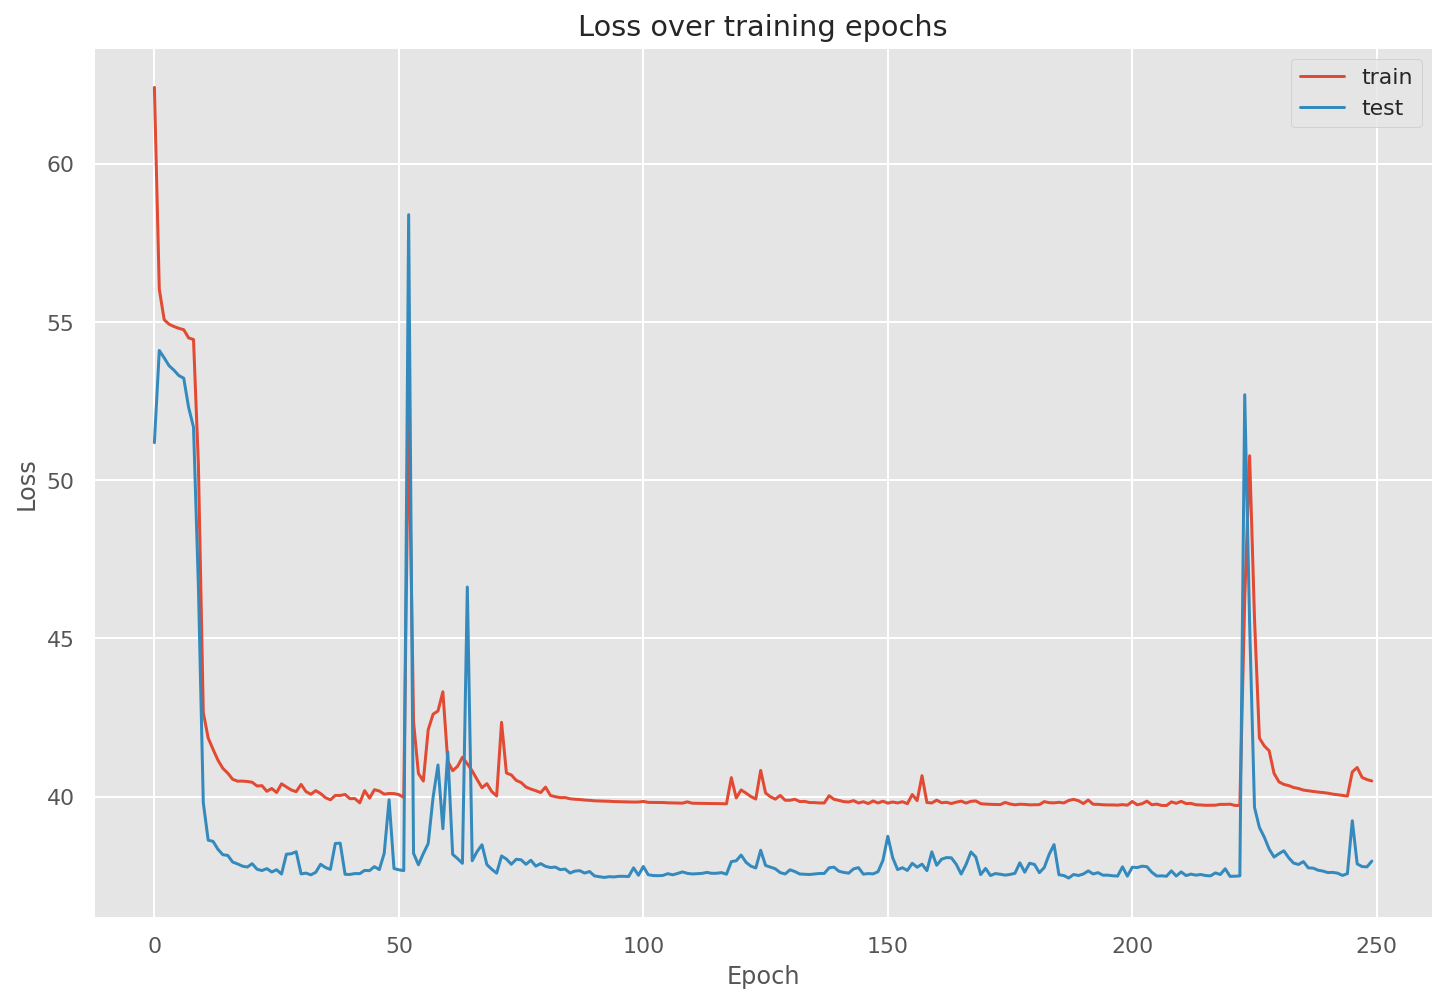

In [59]:

ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [60]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

In [61]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


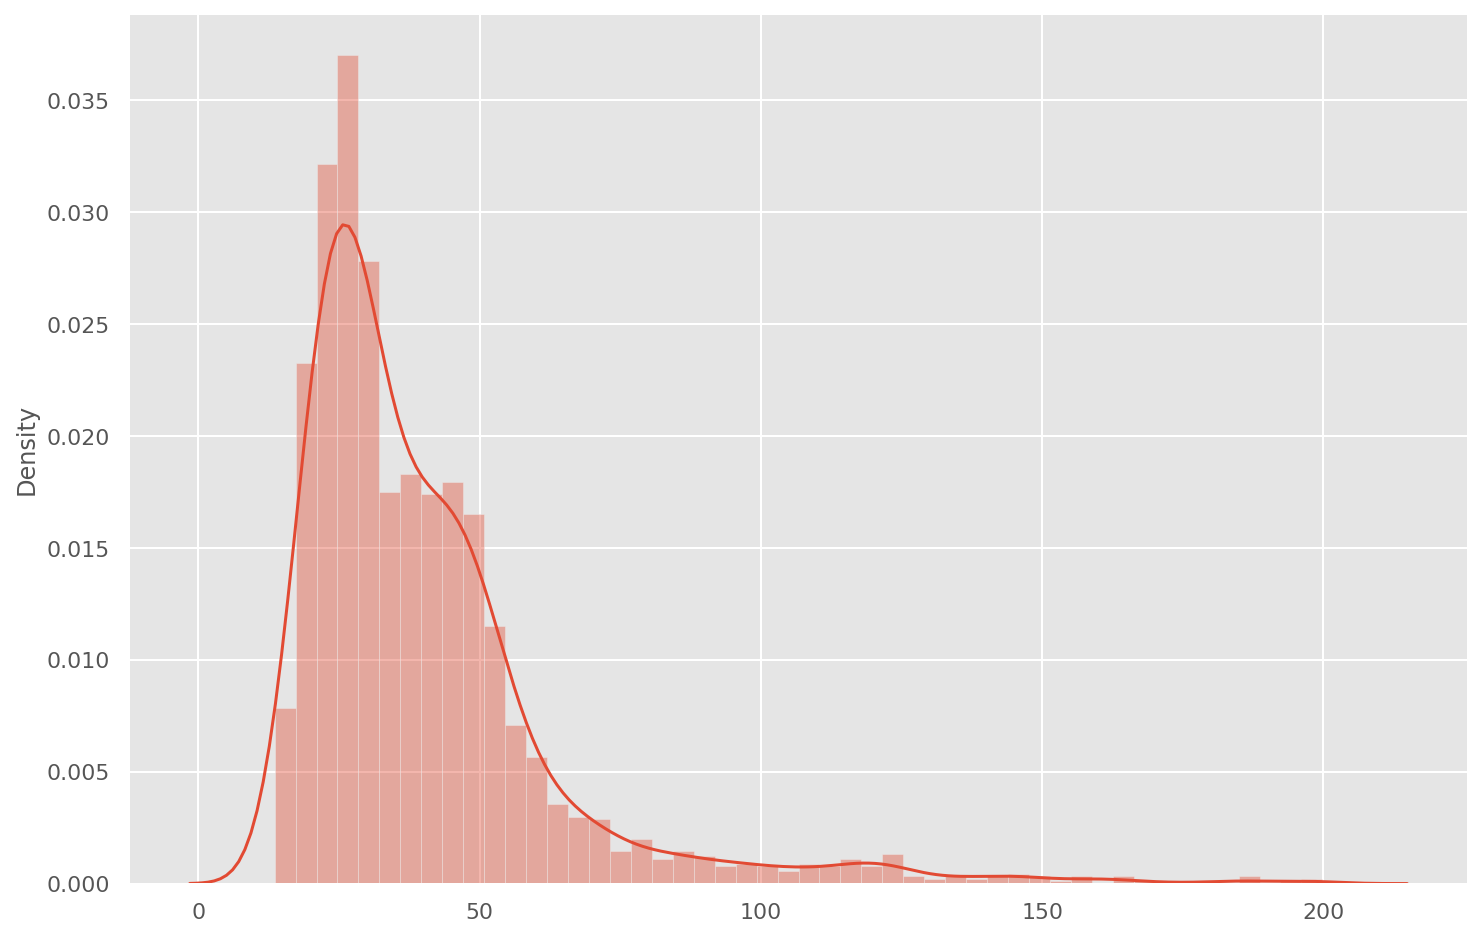

In [62]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [63]:
THRESHOLD = 70

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


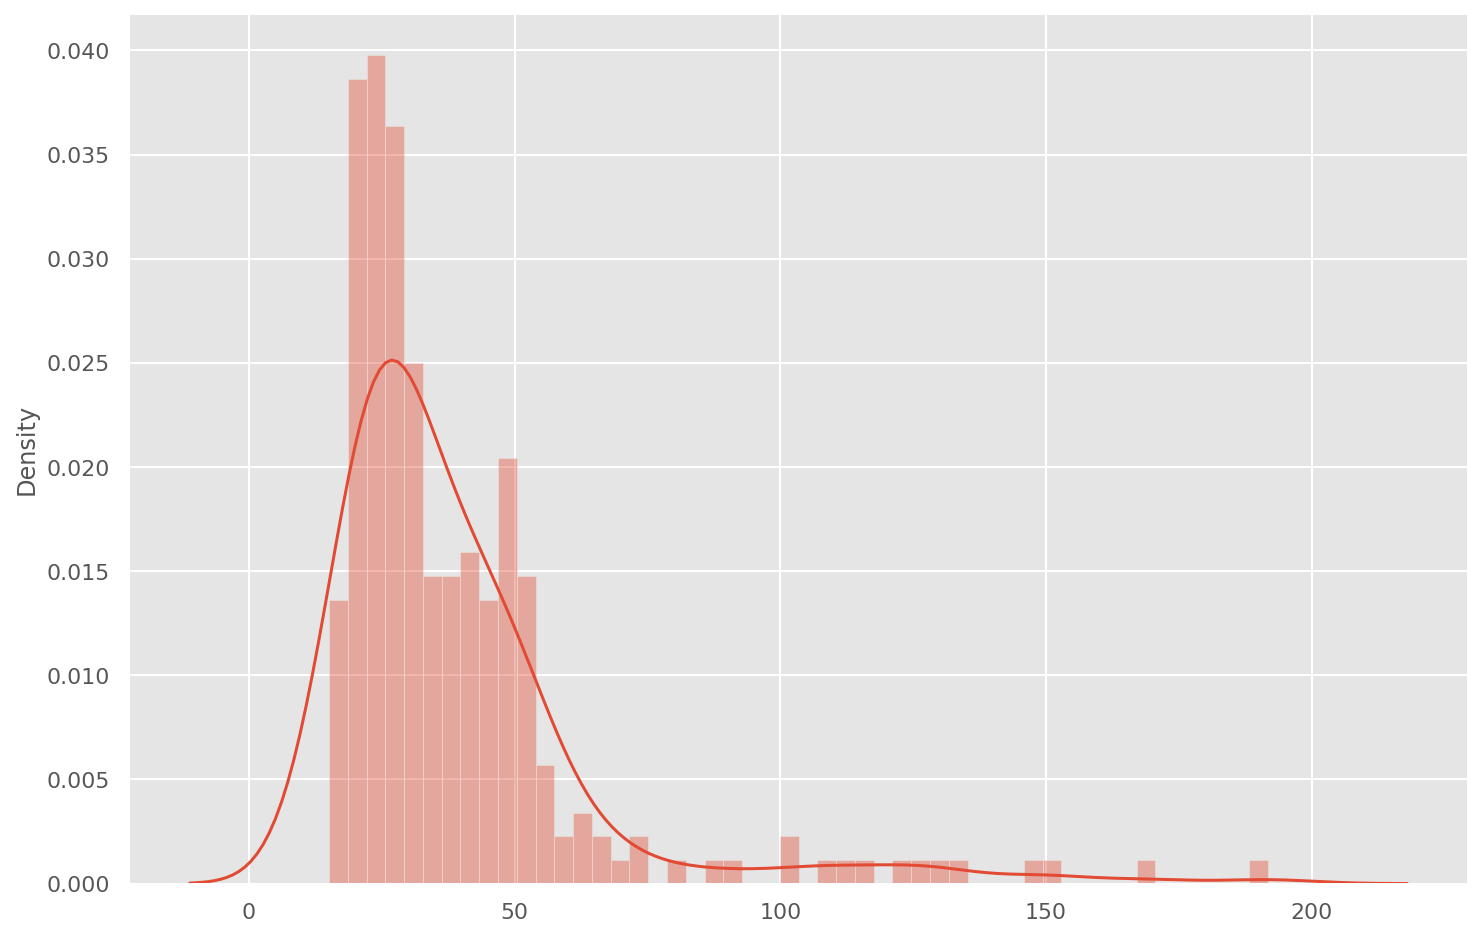

In [64]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [65]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 231/249


### Anomaly

In [66]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


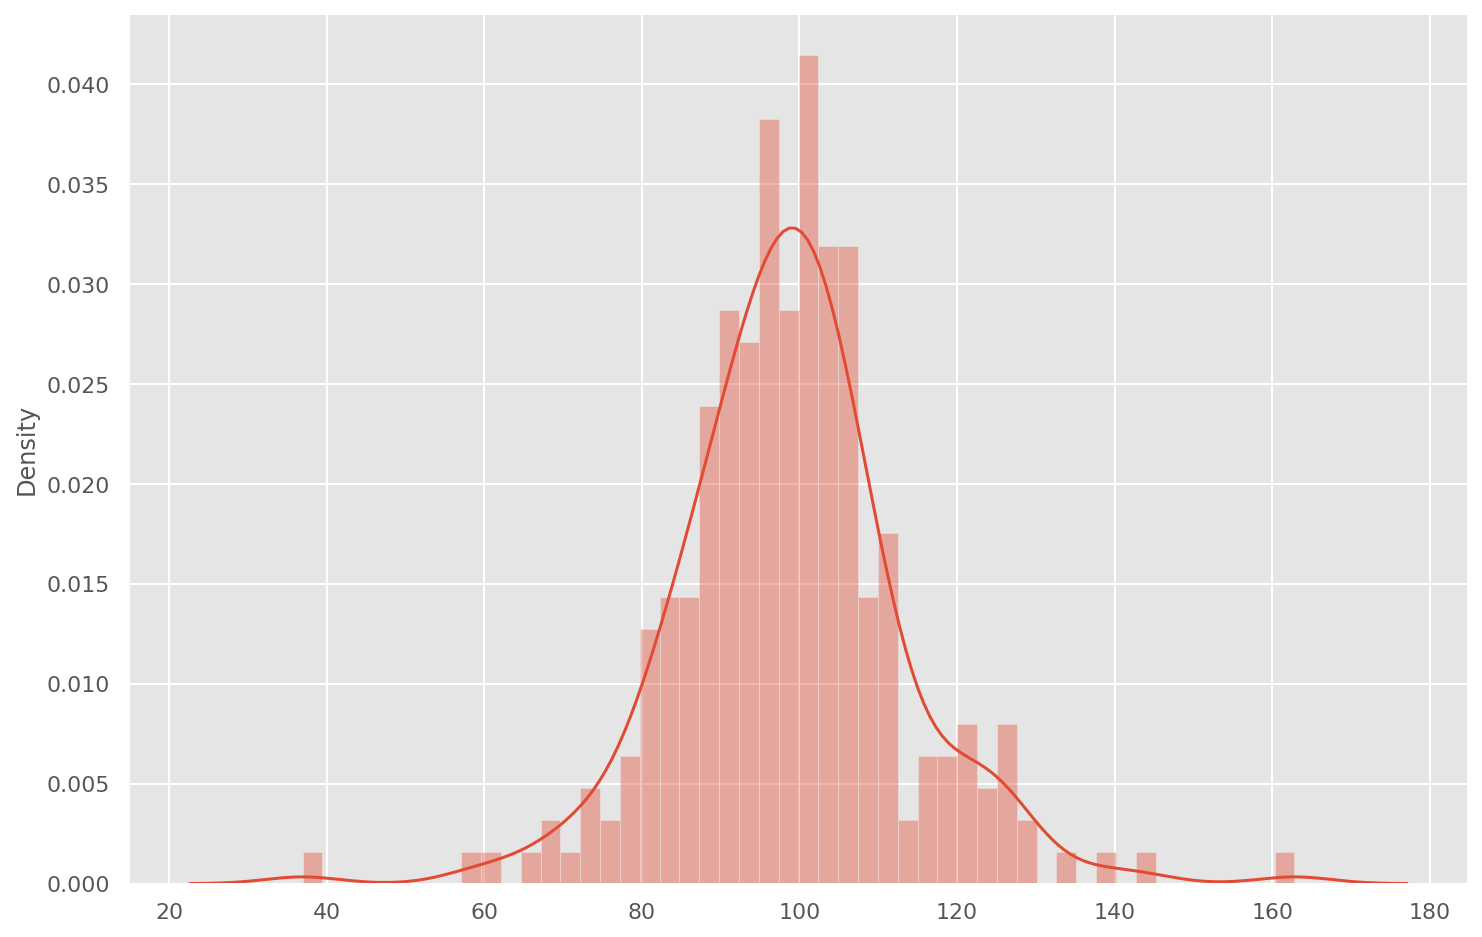

In [67]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [68]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 243/249


In [69]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])
  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

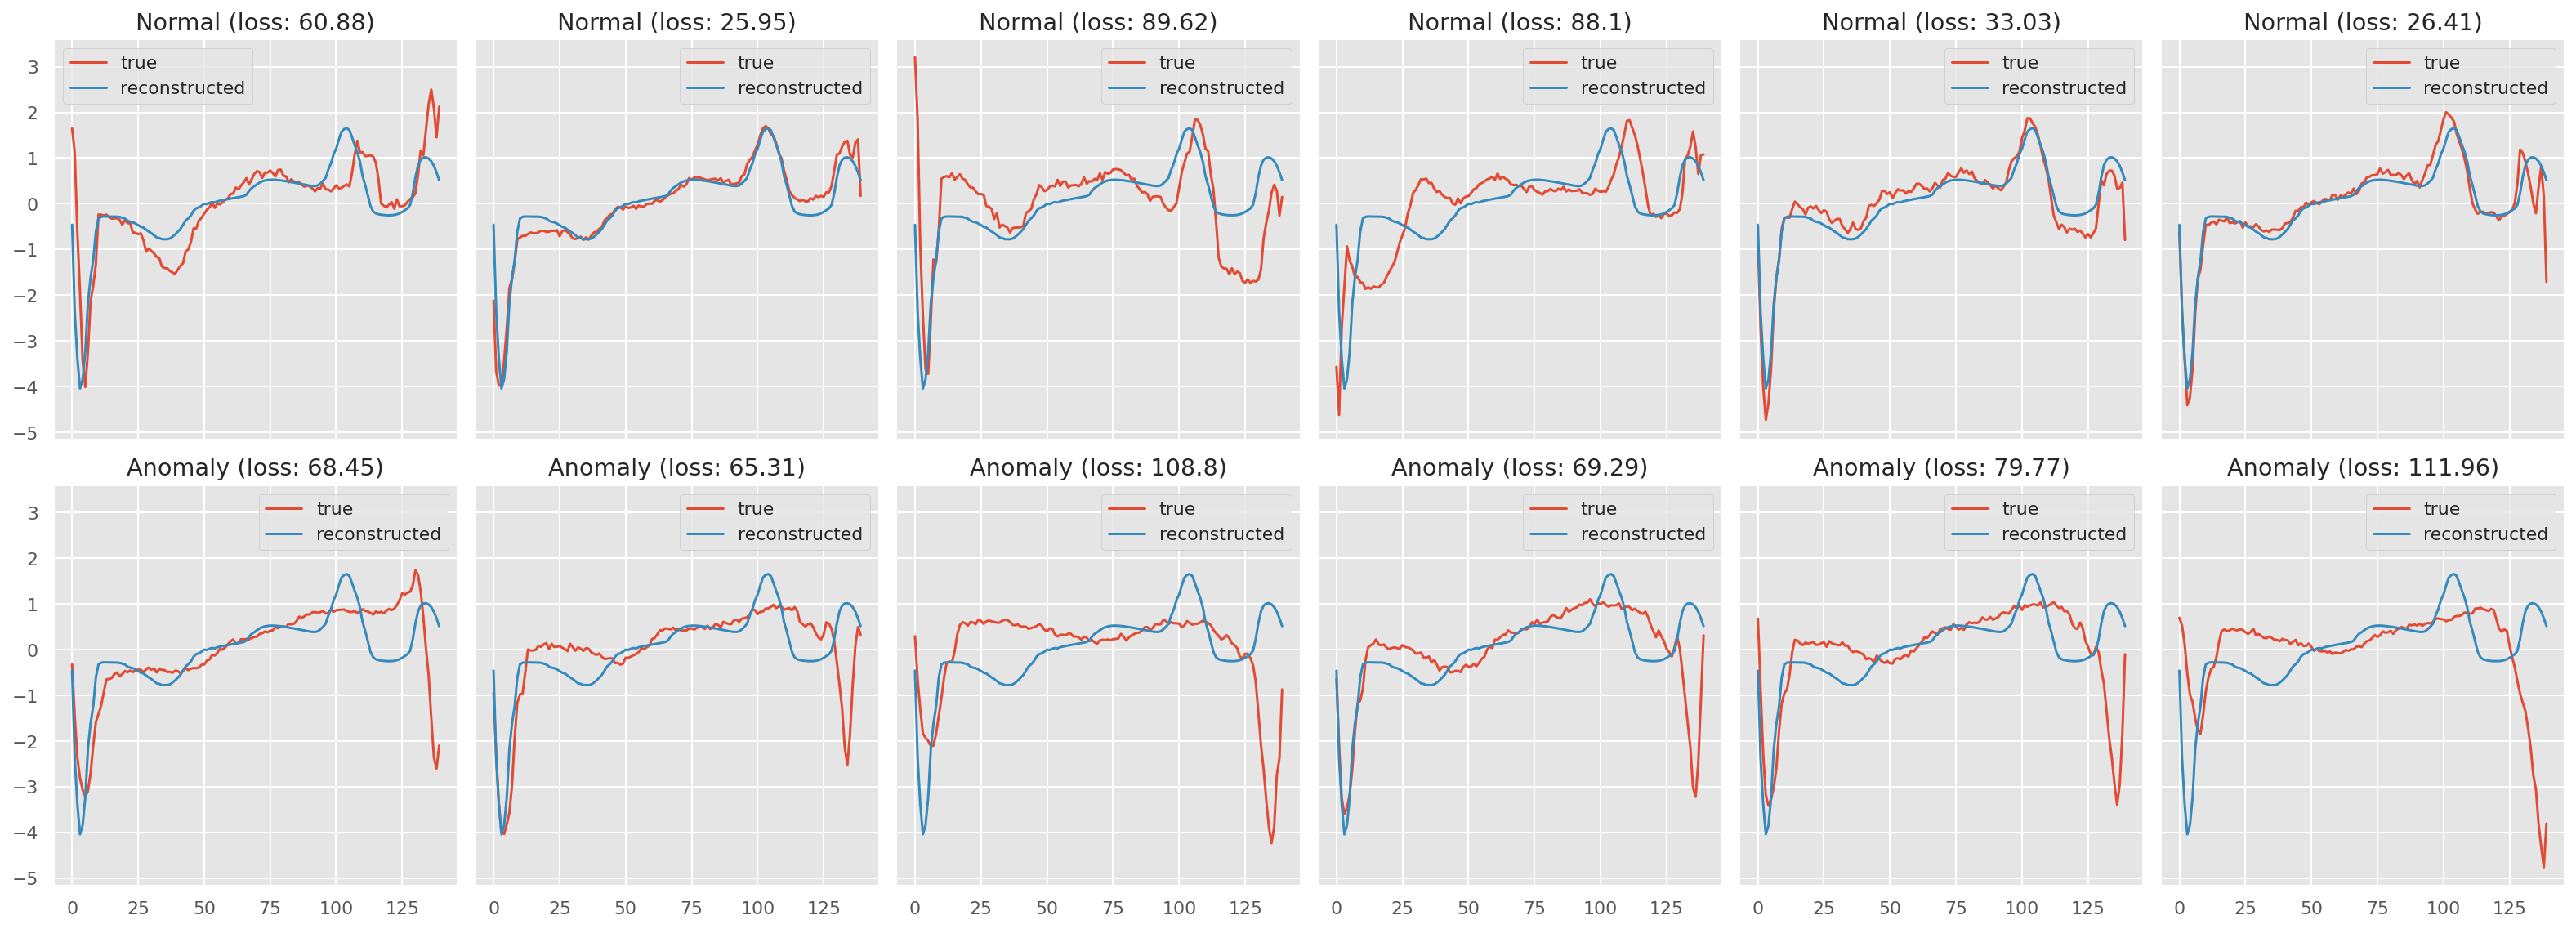

In [70]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)
for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])
for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])
fig.tight_layout();